<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [297]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [298]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-09-08 16:04:01--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.001s  

2020-09-08 16:04:01 (24.4 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [299]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [300]:
df.shape

(346, 10)

### Convert to date time object 

In [301]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [302]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [303]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



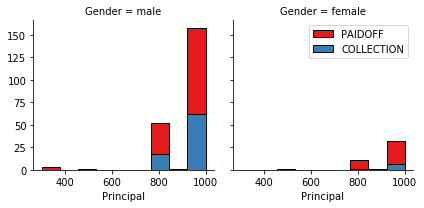

In [304]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

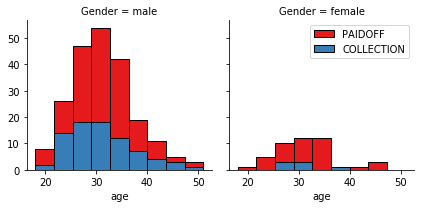

In [305]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

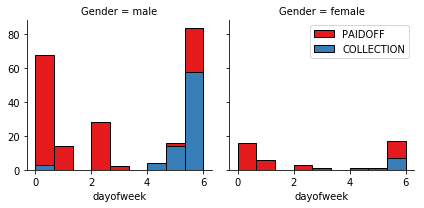

In [306]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

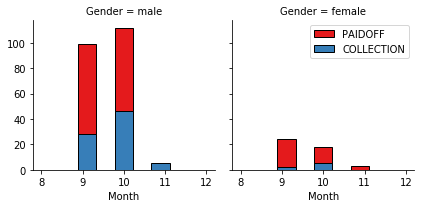

In [307]:
df['Month'] = df.due_date.dt.month
bins = np.linspace(df.Month.min()-1, df.Month.max()+1, 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Month', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [308]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,10,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,10,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,9,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,10,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,10,1


## Convert Categorical features to numerical values

Lets look at gender:

In [309]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [310]:
df['Gender']=df.Gender.astype(object)
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,10,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,10,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,9,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,10,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,10,1


In [311]:
df['deadline']=df['due_date']-df['effective_date']

df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend,deadline
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,10,0,29 days
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,10,0,29 days
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,9,0,14 days
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,10,1,29 days
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,10,1,29 days


In [312]:
df['deadline']=df['deadline'].dt.days
df.head(3)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend,deadline
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,10,0,29
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,10,0,29
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,9,0,14


## One Hot Encoding  
#### How about education?

In [313]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [314]:
len(df[df.education=='Master or Above'])

2

In [315]:
Feature = df[['Principal','terms','age','Gender','weekend','dayofweek']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,dayofweek,Bechalor,High School or Below,college
0,1000,30,45,0,0,3,0,1,0
1,1000,30,33,1,0,3,1,0,0
2,1000,15,27,0,0,3,0,0,1
3,1000,30,28,1,1,4,0,0,1
4,1000,30,29,0,1,4,0,0,1


### Feature selection

Lets defind feature sets, X:

In [316]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,dayofweek,Bechalor,High School or Below,college
0,1000,30,45,0,0,3,0,1,0
1,1000,30,33,1,0,3,1,0,0
2,1000,15,27,0,0,3,0,0,1
3,1000,30,28,1,1,4,0,0,1
4,1000,30,29,0,1,4,0,0,1


What are our lables?

In [317]:
# We encode our labels as 0 and 1 s
y = df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).values
y[0:5]

array([0, 0, 0, 0, 0])

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [318]:
X= preprocessing.StandardScaler().fit_transform(X.astype(float))
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.26122054, -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
        -0.26122054,  2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.26122054, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
         0.12175534, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
         0.12175534, -0.38170062, -0.87997669,  1.14984679]])

In [319]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

In [320]:
X_train, y_train=X,y

In [321]:
X_train.shape, y_train.shape

((346, 9), (346,))

In [322]:
trainScores= list()

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [323]:

from sklearn.neighbors import KNeighborsClassifier

bestScore=0.0
accList=[]

for k in range(3,12):
    
    clf_knn = KNeighborsClassifier(n_neighbors=k,algorithm='auto')
    
    # using 10 fold cross validation for scoring the classifier's accuracy
    scores = cross_val_score(clf_knn, X, y, cv=10)
    score=scores.mean()
    accList.append(score)
    
    if score > bestScore:
        bestScore=score
        best_clf=clf_knn
        bestK=k
        
print("Best K is :",bestK,"| Cross validation Accuracy :",bestScore)
clf_knn=best_clf

Best K is : 8 | Cross validation Accuracy : 0.7522689075630252


In [324]:
clf_knn.fit(X_train,y_train)
y_pred=best_clf.predict(X_train)

In [325]:
knnScores = {}
knnScores['Algorithm'] = 'KNN'
knnScores['Jaccard']=jaccard_similarity_score(y_train, y_pred)
knnScores['F1-score']=f1_score(y_train, y_pred, average='weighted')
knnScores['LogLoss']= None

trainScores.append(knnScores)

In [326]:
print("Train Scores")
knnScores

Train Scores


{'Algorithm': 'KNN',
 'Jaccard': 0.7947976878612717,
 'F1-score': 0.7701843558681992,
 'LogLoss': None}

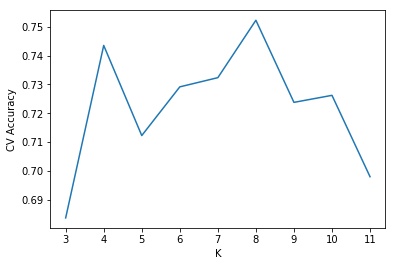

In [327]:
plt.plot(range(3,12),accList)
plt.xlabel('K')
plt.ylabel('CV Accuracy')
plt.show()

# Decision Tree

In [328]:
from sklearn import tree

clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X_train, y_train)

y_pred=clf_tree.predict(X_train)

In [329]:
treeScores = {}
treeScores['Algorithm'] = 'Decision Tree'
treeScores['Jaccard']=jaccard_similarity_score(y_train, y_pred)
treeScores['F1-score']=f1_score(y_train, y_pred, average='weighted')
treeScores['LogLoss'] = None
trainScores.append(treeScores)

In [330]:
treeScores

{'Algorithm': 'Decision Tree',
 'Jaccard': 0.9277456647398844,
 'F1-score': 0.924927020820985,
 'LogLoss': None}

# Support Vector Machine

In [331]:
y_train=y_train.astype(float)

In [332]:
from sklearn import svm

clf_svm = svm.LinearSVC(random_state=7)
clf_svm.fit(X_train, y_train)  

y_pred=clf_svm.predict(X_train)

In [333]:
svmScores = {}
svmScores['Algorithm'] = 'SVM'
svmScores['Jaccard']=jaccard_similarity_score(y_train, y_pred)
svmScores['F1-score']=f1_score(y_train, y_pred, average='weighted')
svmScores['LogLoss'] = None
trainScores.append(svmScores)

In [334]:
svmScores

{'Algorithm': 'SVM',
 'Jaccard': 0.7514450867052023,
 'F1-score': 0.6689062277741139,
 'LogLoss': None}

# Logistic Regression

In [335]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial')
clf_log.fit(X_train, y_train)

y_pred=clf_log.predict(X_train)
y_proba=clf_log.predict_proba(X_train)

In [336]:
logregScores = {}
logregScores['Algorithm'] = 'LogisticRegression'
logregScores['Jaccard']=jaccard_similarity_score(y_train, y_pred)
logregScores['F1-score']=f1_score(y_train, y_pred, average='weighted')  
logregScores['LogLoss']=log_loss(y_train, y_proba)
trainScores.append(logregScores)

In [337]:
logregScores

{'Algorithm': 'LogisticRegression',
 'Jaccard': 0.7630057803468208,
 'F1-score': 0.7088399037150602,
 'LogLoss': 0.43174993676801543}

# Model Evaluation using Test set


In [338]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-09-08 16:06:30--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-09-08 16:06:31 (316 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [339]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [340]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df['Gender']=test_df.Gender.astype(object)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# test_df['Month'] = test_df.due_date.dt.month 

# test_df['deadline']=test_df['due_date']-test_df['effective_date']
# test_df['deadline']=test_df['deadline'].dt.days

Feature = test_df[['Principal','terms','age','Gender','weekend','dayofweek']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

X = Feature

y = test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).values

testy=y.astype(float)
testX= preprocessing.StandardScaler().fit_transform(X.astype(float))

In [341]:
testScores= list()

In [342]:
knn_pred=kNN_model.predict(test_X)
knnscoret = {}
knnscoret['Algorithm'] = 'KNN'
knnscoret['Jaccard']=jaccard_similarity_score(test_y, knn_yhat)
knnscoret['F1-score']=f1_score(test_y, knn_yhat, average='weighted')
knnscoret['LogLoss'] = None
testScores.append(knnscoret)

In [343]:
tree_pred=DT_model.predict(test_X)
treescoret = {}
treescoret['Algorithm'] = 'Decision Tree'
treescoret['Jaccard']=jaccard_similarity_score(test_y, DT_yhat)
treescoret['F1-score']=f1_score(test_y, DT_yhat, average='weighted')
testScores.append(treescoret)

In [344]:
svm_pred=SVM_model.predict(test_X)
svmscoret = {}
svmscoret['Algorithm'] = 'SVM'
svmscoret['Jaccard']=jaccard_similarity_score(test_y, SVM_yhat)
svmscoret['F1-score']=f1_score(test_y, SVM_yhat, average='weighted')
svmscoret['LogLoss'] = None
testScores.append(svmscoret)

In [345]:
log_pred=clf_log.predict(testX)
proba=clf_log.predict_proba(testX)
logscoret = {}
logscoret['Algorithm'] = 'LogisticRegression'
logscoret['Jaccard']=jaccard_similarity_score(testy, log_pred)
logscoret['F1-score']=f1_score(testy, log_pred, average='weighted')  
logscoret['LogLoss']=log_loss(testy, proba)
testScores.append(logscoret)

In [346]:
trainScores

[{'Algorithm': 'KNN',
  'Jaccard': 0.7947976878612717,
  'F1-score': 0.7701843558681992,
  'LogLoss': None},
 {'Algorithm': 'Decision Tree',
  'Jaccard': 0.9277456647398844,
  'F1-score': 0.924927020820985,
  'LogLoss': None},
 {'Algorithm': 'SVM',
  'Jaccard': 0.7514450867052023,
  'F1-score': 0.6689062277741139,
  'LogLoss': None},
 {'Algorithm': 'LogisticRegression',
  'Jaccard': 0.7630057803468208,
  'F1-score': 0.7088399037150602,
  'LogLoss': 0.43174993676801543}]

In [347]:
testScores

[{'Algorithm': 'KNN',
  'Jaccard': 0.6666666666666666,
  'F1-score': 0.6328400281888654,
  'LogLoss': None},
 {'Algorithm': 'Decision Tree',
  'Jaccard': 0.7222222222222222,
  'F1-score': 0.7366818873668188},
 {'Algorithm': 'SVM',
  'Jaccard': 0.7962962962962963,
  'F1-score': 0.7583503077293734,
  'LogLoss': None},
 {'Algorithm': 'LogisticRegression',
  'Jaccard': 0.7777777777777778,
  'F1-score': 0.708937198067633,
  'LogLoss': 0.4739578521073105}]

In [348]:
list(Feature.columns)

['Principal',
 'terms',
 'age',
 'Gender',
 'weekend',
 'dayofweek',
 'Bechalor',
 'High School or Below',
 'college']

In [351]:
report = pd.DataFrame(trainScores, index=None)
report = report.set_index(['Algorithm', "F1-score", 'Jaccard', 'LogLoss'])
report

,,,
Algorithm,F1-score,Jaccard,LogLoss
KNN,0.770184,0.794798,NaN
Decision Tree,0.924927,0.927746,NaN
SVM,0.668906,0.751445,NaN
LogisticRegression,0.708840,0.763006,0.43175
